> The code is provided under AGPL License. You can find out more [here](https://www.gnu.org/licenses/agpl-3.0.en.html).

> All material is licensed under the Creative Commons Attribution-ShareAlike 4.0 International license or newer (CC BY-SA 4.0). 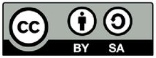

>Errikos Streviniotis, Nikos Giatrakos, Technical University of Crete & Athena RC, 2023 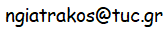

# Acknowledgements
Research Funded by the EU Horizon Europe by the EU project EVENFLOW under Horizon Europe agreement No. 101070430
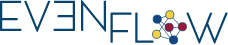



In this notebook we utilize kafka and **brute force** search in order to select the exact values of several *hyper-parameters* based on a specific CNN architecture with respect to a score. In particular:


1.   We load our dataset (cifar10, cifar100, mnist, fashion_mnist)
2.   We send our data to the corresponding kafka-topics (both training and testing samples)
3.   We read the data from topics
4.   We employ **brute force** search in order to select the combinations of *hyper-parameters* that maximize a specific score based on a specific CNN architecture.

> NOTE: The *hyper-parameters* are the following:


> - Sampling size
> - \# of epochs during training
> - \# of neurons after each layer

> NOTE: Our metric is one that captures the tradeoff between the accuracy on the testing set and the training speed of our CNN.

# Install and Import all the necessary packages and libraries

Install the required tensorflow-io and kafka packages

In [ ]:
!pip install tensorflow-io
!pip install kafka-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 40.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 9.7 MB/s eta 0:00:00


Import packages

In [ ]:
import os
import sys
import random
from datetime import datetime
import time
import math
import decimal
import threading
import json
from kafka import KafkaProducer, KafkaConsumer
from kafka.errors import KafkaError
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.datasets import fashion_mnist, mnist, cifar10, cifar100
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras import backend as K

# Definition of programmer's parameters (Controller's block)

In [ ]:
# Our dataset
dataset = cifar10.load_data() #@param

# This variable corresponds to the number of messages that will be sent to kafka,
# and as a result the number of samples that will be used for the training - testing
tmp_filter_train = 50000 #@param
tmp_filter_test = 10000 #@param

# Percentage of the dataset that will be used for training
sample_size_low = 0.1 #@param {type:"number"}
sample_size_high = 0.5 #@param {type:"number"}
sample_size_step = 0.1 #@param {type:"number"}

# This block of code creates a list that contain all the floats between
# [sample_size_low, sample_size_high] with step sample_size_step
# Unfortunately, range() does not operate with floats but only with int
sample_size_tmp = list(np.arange(sample_size_low, sample_size_high + sample_size_step, sample_size_step))
for i in range(0, len(sample_size_tmp)):
  sample_size_tmp[i] = round(sample_size_tmp[i], 2)
sample_size_all = list(filter(lambda item: item <= sample_size_high, sample_size_tmp))

#
#
#
#
# Optional: Determine manually the sample sizes without init-final-step values...
# This is usefull for example in the case of TB -> GB -> MB
# where user determines specific values
#sample_size_all = [0.01, 0.1, 1]
#
#
#
#

# Percentage of the dataset that will be used for testing
perc_test = 1 #@param {type:"number"}

# The ID of the method that will be employed during sampling
# 0: Simple reservoir sampling in our initial training dataset
# 1: Reservoir sampling in each class based on the number of samples (per class)
sampling_method_id = 1 #@param {type:"integer"}

##################################################
# CONVOLUTIONAL LAYERS INPUT
##################################################
num_of_conv_layers = 2 #@param {type:"integer"}

##################################################
# POOLING LAYERS INPUT
##################################################
num_of_pool_layers = 2 #@param {type:"integer"}

##################################################
# DENSE LAYERS INPUT
##################################################
num_of_dense_layers = 1 #@param {type:"integer"}

##################################################
# RANGE OF NEURONS (AND STEP SIZE) INPUT
##################################################
# INIT NUMBER FOR NEURONS INPUT
init_num_neurons = 32 #@param {type:"integer"}

# LAST NUMBER FOR NEURONS INPUT
last_num_neurons = 32 #@param {type:"integer"}

# STEP SIZE INPUT
step = 32 #@param {type:"integer"}

# Number of epochs for the training process
# One Epoch is when an ENTIRE (training) dataset is passed forward and backward through the neural network only once.
# NOTE: An epoch is comprised of one or more batches.
num_of_epochs_low = 1 #@param {type:"integer"}
num_of_epochs_high = 21 #@param {type:"integer"}
num_of_epochs_step = 5 #@param {type:"integer"}

# The size of the batch for the training process
# Total number of training examples present in a single batch.
# or, number of samples processed before the model is updated.
size_of_batch = 32 #@param {type:"integer"}

# The value for the learning rate for the training process (it is inserted to the Adam optimizer)
# During the optimization, the algorithm needs to take a series of tiny steps to descend the error mountain in order to minimize the error.
# The direction of the step is determined by the gradient, while the step size is determined by the learning rate.
lr_alpha = 0.001 #@param {type:"number"}

# Maximum training time above which we cancel the experiment (in seconds)
# It is used in the score (accuracy--speed tradeoff) formula
theta_parameter = 8 #@param {type:"integer"}

# Weight for the accuracy of the model. Max value: 0.99
# There is also the weight of training speed of the model (1 - lamda_acc)
# It is used in the score (accuracy--speed tradeoff) formula
lamda_acc = 0.5 #@param {type:"number"}


170498071/170498071 [==============================] - 3s 0us/step


# Download and setup **Kafka** and **Zookeeper** instances

In [ ]:
!curl -sSOL https://dlcdn.apache.org/kafka/3.4.1/kafka_2.13-3.4.1.tgz
!tar -xzf kafka_2.13-3.4.1.tgz

In [ ]:
!./kafka_2.13-3.4.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.4.1/config/zookeeper.properties
!./kafka_2.13-3.4.1/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.4.1/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [ ]:
!ps -ef | grep kafka

Create the kafka topics with the following specs:

- train-labels-mnist: partitions=1, replication-factor=1
- train-images-mnist: partitions=1, replication-factor=1

In [ ]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic train-labels
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic train-images

Created topic train-labels.
Created topic train-images.


In [ ]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic test-labels
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic test-images

Created topic test-labels.
Created topic test-images.


In [ ]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic train-labels
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic train-images

Topic: train-labels	TopicId: vQeCK0jmS4O76jDTtOyuiA	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: train-labels	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: train-images	TopicId: 4cSKJHUsSeafaRS56T870w	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: train-images	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


In [ ]:
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic test-labels
!./kafka_2.13-3.4.1/bin/kafka-topics.sh --describe --bootstrap-server 127.0.0.1:9092 --topic test-images

Topic: test-labels	TopicId: KXWYg06DTyuqltH99iJmjQ	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: test-labels	Partition: 0	Leader: 0	Replicas: 0	Isr: 0
Topic: test-images	TopicId: Tl5b_eaUSTaGEIPe79rW6A	PartitionCount: 1	ReplicationFactor: 1	Configs: 
	Topic: test-images	Partition: 0	Leader: 0	Replicas: 0	Isr: 0


# Load of our Dataset

Upload our dataset and normalize it

In [ ]:
# Load mnist (or fashion_mnist) dataset
(x_train, y_train), (x_test, y_test) = dataset

# Scale images to the [0, 1] range
x_train = x_train / 255
x_test = x_test / 255

if len(x_train.shape) == 3:
  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)
  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")


In [ ]:
# The type of input based on the corresponding dataset
dataset_shape = x_train.shape[1:]

# Kafka (send and receive the data)

Send the **training** data (images and corresponding labels) to kafka appropriate topics

In [ ]:
# Producer part
def error_callback(exc):
    raise Exception('Error while sendig data to kafka: {0}'.format(str(exc)))

def write_to_kafka(topic_name, x_tmp, y_tmp):
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  count = 0
  for (x, y) in zip(x_tmp, y_tmp):
    if topic_name == 'train-images':
      # Tranform data to bytes
      msg = x.tobytes()
      producer.send(topic_name, msg).add_errback(error_callback)
      producer.flush()
      count += 1
    else:
      yy = np.uint8(y.item())
      str_msg = yy.astype(str)
      # Tranform data to bytes and send to producer
      producer.send(topic_name, bytes(str_msg, 'utf-8')).add_errback(error_callback)
      producer.flush()
      count += 1
    if count >= tmp_filter_train:
      break

  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

# Write to kafka the training images
write_to_kafka("train-images", x_train, y_train)
# Write to kafka the labels of the training images
write_to_kafka("train-labels", x_train, y_train)

Wrote 50000 messages into topic: train-images
Wrote 50000 messages into topic: train-labels


Send the **testing** data (images and corresponding labels) to kafka appropriate topics

In [ ]:
def write_to_kafka_test(topic_name, x_tmp, y_tmp):
  producer = KafkaProducer(bootstrap_servers=['127.0.0.1:9092'])
  count = 0
  for (x, y) in zip(x_tmp, y_tmp):
    if topic_name == 'test-images':
      # Tranform data to bytes
      msg = x.tobytes()
      producer.send(topic_name, msg).add_errback(error_callback)
      producer.flush()
      count += 1
    else:
      yy = np.uint8(y.item())
      str_msg = yy.astype(str)
      # Tranform data to bytes and send to producer
      producer.send(topic_name, bytes(str_msg, 'utf-8')).add_errback(error_callback)
      producer.flush()
      count += 1
    if count >= tmp_filter_test:
      break

  print("Wrote {0} messages into topic: {1}".format(count, topic_name))

# Write to kafka the training images
write_to_kafka_test("test-images", x_test, y_test)
# Write to kafka the labels of the training images
write_to_kafka_test("test-labels", x_test, y_test)

Wrote 10000 messages into topic: test-images
Wrote 10000 messages into topic: test-labels


De-code the **training** images that were sent to kafka



In [ ]:
# Consumer-part for images
consumer_images = KafkaConsumer("train-images", group_id = 'group1', bootstrap_servers = ['127.0.0.1:9092'], auto_offset_reset = 'earliest')
try:
  tmp_count = 0
  received_images = []
  for message in consumer_images:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    decode_img = np.frombuffer(message.value)
    received_images.append(decode_img)
    del decode_img
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_train:
      break
except KeyboardInterrupt:
    sys.exit()

De-code the **testing** images that were sent to kafka

In [ ]:
# Consumer-part for images
consumer_images_test = KafkaConsumer("test-images", group_id = 'group3', bootstrap_servers = ['127.0.0.1:9092'], auto_offset_reset = 'earliest')
try:
  tmp_count = 0
  received_images_test = []
  for message in consumer_images_test:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    decode_img = np.frombuffer(message.value)
    received_images_test.append(decode_img)
    del decode_img
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_test:
      break
except KeyboardInterrupt:
    sys.exit()

Reshape the received **training** images

In [ ]:
received_images_reshaped = []
for i in range(0, len(received_images)):
  r = received_images[i].reshape(dataset_shape)
  received_images_reshaped.append(r)

Reshape the received **testing** images

In [ ]:
received_images_reshaped_test = []
for i in range(0, len(received_images_test)):
  r = received_images_test[i].reshape(dataset_shape)
  received_images_reshaped_test.append(r)

Receive the **training** labels that were sent to kafka

In [ ]:
consumer_labels = KafkaConsumer("train-labels", group_id = 'group2', bootstrap_servers = ['127.0.0.1:9092'], auto_offset_reset = 'earliest')
try:
  tmp_count = 0
  received_labels = []
  for message in consumer_labels:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    received_labels.append(message.value)
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_train:
      break
except KeyboardInterrupt:
    sys.exit()

Receive the **testing** labels that were sent to kafka

In [ ]:
consumer_labels_test = KafkaConsumer("test-labels", group_id = 'group4', bootstrap_servers = ['127.0.0.1:9092'], auto_offset_reset = 'earliest')
try:
  tmp_count = 0
  received_labels_test = []
  for message in consumer_labels_test:
    #print ("%s:%d:%d: key=%s value=%s" % (message.topic, message.partition, message.offset, message.key, message.value))
    received_labels_test.append(message.value)
    tmp_count = tmp_count + 1
    if tmp_count >= tmp_filter_test:
      break
except KeyboardInterrupt:
    sys.exit()

Decode the received **training** labels

In [ ]:
received_labels_decoded = []
for i in range(0, len(received_labels)):
  l = int(received_labels[i].decode("utf-8"))
  received_labels_decoded.append(l)

Decode the received **testing** labels

In [ ]:
received_labels_decoded_test = []
for i in range(0, len(received_labels_test)):
  l = int(received_labels_test[i].decode("utf-8"))
  received_labels_decoded_test.append(l)

Verify that everything performs as it should... by checking the exact number of received images and labels...

In [ ]:
print("Received Training Data:")
print("------> # of received images:", len(received_images_reshaped))
print("------> # of received labels:", len(received_labels_decoded))

Received Training Data:
------> # of received images: 50000
------> # of received labels: 50000


In [ ]:
print("Received Testing Data:")
print("------> # of received images:", len(received_images_reshaped_test))
print("------> # of received labels:", len(received_labels_decoded_test))

Received Testing Data:
------> # of received images: 10000
------> # of received labels: 10000


# Synopsis block of code

In [ ]:
# Get unique labels in our (received) training dataset
unique_class_labels = np.unique(received_labels_decoded)

In [ ]:
# A function that prints the occurence of each class in a list
def print_times_per_label(lst, labels_all):
  # Get unique labels in our training dataset
  unique_labels = np.unique(labels_all)
  for i in range(0, len(unique_labels)):
    print("Class", unique_labels[i], "has", lst.count(i), "samples in our dataset...")

In [ ]:
# Select k items from a stream of items-data

# A function to randomly select k items from stream[0..n-1].
def reservoir_sampling(stream, n, k):
  i = 0     # index for elements in stream[]

  # reservoir[] is the output array.
  # Initialize it with first k elements from stream[]
  reservoir = [0] * k

  for i in range(k):
    reservoir[i] = stream[i]

  # Iterate from the (k+1)th element to Nth element
  while(i < n):
    # Pick a random index from 0 to i.
    j = random.randrange(i+1)

    # If the randomly picked
    # index is smaller than k,
    # then replace the element
    # present at the index
    # with new element from stream
    if(j < k):
      reservoir[j] = stream[i]
    i+=1

  return reservoir

In [ ]:
# A function that finds the size of each reservoir for every class depending on its occurence in the initial dataset
# and returns the unique labels that exist in our dataset along with the corresponding percentage
def reservoir_size_per_class(init_labels):

  # Get unique labels and their counts (how many times they appear) in our training dataset
  unique_labels, counts = np.unique(init_labels, return_counts = True)

  # Transform to list
  unique_labels_lst = unique_labels.tolist()
  counts_lst = counts.tolist()

  perc_per_class = []
  for i in range(len(unique_labels_lst)):
    perc_per_class.append(counts_lst[i]/len(init_labels))

  # print(perc_per_class)

  return perc_per_class, unique_labels_lst

Sampling - part (for the received data, i.e., received images and labels **only**)

In [ ]:
def sampling_method(sampling_method_id, received_images_reshaped, received_labels_decoded, sample_size):
  print("Percentage of filtering in our training dataset was set:")
  print(sample_size)

  if sampling_method_id == 0:
    # Simple reservoir sampling over the whole training dataset
    # Total size of the stream (or training dataset)
    n_train = len(received_images_reshaped)

    # Number of samples that will be drawn
    k_train = int(n_train * sample_size)

    # Use the indexes of dataset in order to decide which samples will be drawn
    idx_tmp_train_list = list(range(0, n_train))

    # Find the indexes in order to construct the dataset that will be used during the training process
    idx_train = reservoir_sampling(idx_tmp_train_list, n_train, k_train)
  else:
    # Reservoir sampling in each class based on the number of samples (per class) that exist in the initial dataset
    # Find the size of each reservoir for every class depending on its occurence in the initial training dataset
    class_perc, unique_ids = reservoir_size_per_class(received_labels_decoded)
    print(class_perc)
    # Stores the indexes (from all classes) in order to construct the dataset that will be used during the training process
    idx_train = []

    # Run for every single class the reservoir sampling seperately
    for i in range(0, len(unique_ids)):
      # Find the locations of each sample belonging to our class of interest
      tmp = np.where(np.asarray(received_labels_decoded) == unique_ids[i])
      idx_of_class = tmp[0].tolist()

      # Run the reservoir sampling for the class of interest
      sampled_idx_of_class = reservoir_sampling(idx_of_class, len(idx_of_class), int(len(received_images_reshaped) * sample_size * class_perc[i]))

      # Store the (sampled) samples from this class
      for j in range(0, len(sampled_idx_of_class)):
        idx_train.append(sampled_idx_of_class[j])

  # Store the corresponding images and labels from training dataset based on the sampled indexes
  train_images_lst = []
  for i in idx_train:
    train_images_lst.append(received_images_reshaped[i])

  train_labels_lst = []
  for i in idx_train:
    train_labels_lst.append(received_labels_decoded[i])

  # Check the occurence of each class in the final training dataset
  print_times_per_label(train_labels_lst, received_labels_decoded)

  # Tranfsorm the lists that we stored our samples into arrays
  train_images = np.asarray(train_images_lst)
  train_labels = np.asarray(train_labels_lst)

  # Verify that the desired filtering was performed in both datasets
  print("Training dataset before sampling:")
  print(len(received_images_reshaped))
  print(len(received_labels_decoded))
  print("Training dataset after sampling:")
  print(train_images.shape)
  print(train_labels.shape)

  return train_images, train_labels

# Function for finding all possible combinations (of k-length) from a list of elements, i.e., alphabet

In [ ]:
# Find all possible combinations of length k
def printAllKLength(lst, k, comb_of_neurons):
  n = len(lst)
  tmp = []
  printAllKLengthRec(lst, tmp, n, k, comb_of_neurons)


# The main recursive method for finding all possible combinations of length k
def printAllKLengthRec(lst, prefix, n, k, comb_of_neurons):

	# Base case: k is 0,
	if (k == 0) :
		comb_of_neurons.append(prefix)
		#print(prefix)
		return

	# One by one add all elements
	# from set and recursively
	# call for k equals to k-1
	for i in range(n):
		newPrefix = prefix.copy()

		# Next element of input added
		newPrefix.append(lst[i])

		# k is decreased, because we have added a new character
		printAllKLengthRec(lst, newPrefix, n, k - 1, comb_of_neurons)

Find all possible combinations of neurons based on user's input

In [ ]:
# Find the valid values of neurons based on user's input
num_neurons = []
for i in range(int(init_num_neurons), int(last_num_neurons) + 1, int(step)):
  num_neurons.append(i)

# Number of neurons that we will search
print("Our alphabet:")
print(num_neurons)
print ("All permutations with repetition of neurons are:")
comb_of_neurons = []

# Change based on the number of convolutional and dende layers that were given as input from the user
k = int(num_of_conv_layers) + int(num_of_dense_layers)

printAllKLength(num_neurons, k, comb_of_neurons)

print(comb_of_neurons)
print("The total number of combinations are:")
print(len(comb_of_neurons))

Our alphabet:
[32]
All permutations with repetition of neurons are:
[[32, 32, 32]]
The total number of combinations are:
1


# Brute Force Searching of **optimal** combination of neurons

In [ ]:
# List of valid combinations of neurons given a specific "architecture"
# List of sampling size, epochs that were tested
valid_comb_neurons = []
valid_comb_sample_size = []
valid_comb_epochs = []

# Lists that contain the results (accuracy, train speed and score) for each examined valid combination
valid_comb_score = []
valid_comb_accuracy = []
valid_comb_train_speed = []

# Check all the valid sample size based on user's input
for ss in range(0, len(sample_size_all)):

  sample_size = sample_size_all[ss]

  # Call the sampling method
  train_images, train_labels = sampling_method(sampling_method_id, received_images_reshaped, received_labels_decoded, sample_size)

  # Check all the valid number of epochs based on user's input
  for ep in range(num_of_epochs_low, num_of_epochs_high + 1, num_of_epochs_step):
    # Check all the potential combinations of neurons
    for z in range(0, len(comb_of_neurons)):
      # flag == 1 corresponds to an invalid combination of neurons
      error_flag = -1

      # clear the previous model in order to construct the new one (based on the next set of neurons combination)
      tf.keras.backend.clear_session()

      model = models.Sequential()

      # Combination of neurons that we check in this iteration
      print(comb_of_neurons[z][:])


      ############################################################################################
      # Part I: Convolutional part of our network, i.e., extraction of (important) features
      ############################################################################################

      try:
        if num_of_conv_layers > num_of_pool_layers:
          for i in range(0, int(num_of_conv_layers) - int(num_of_pool_layers)):
            if i == 0:
              model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu', input_shape = dataset_shape))
            else:
              model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu'))

          for i in range(int(num_of_conv_layers) - int(num_of_pool_layers), int(num_of_conv_layers)):
            model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))

        elif num_of_conv_layers == num_of_pool_layers:
          for i in range(0, int(num_of_conv_layers)):
            if i == 0:
              model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu', input_shape = dataset_shape))
              model.add(layers.MaxPooling2D((2, 2)))
            else:
              model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu'))
              model.add(layers.MaxPooling2D((2, 2)))
        else:
          for i in range(0, int(num_of_conv_layers)):
            if i == 0:
              model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu', input_shape = dataset_shape))
              model.add(layers.MaxPooling2D((2, 2)))
            else:
              model.add(layers.Conv2D(comb_of_neurons[z][i], (3, 3), activation='relu'))
              model.add(layers.MaxPooling2D((2, 2)))

          for i in range(int(num_of_conv_layers), int(num_of_pool_layers)):
            model.add(layers.MaxPooling2D((2, 2)))

        # Droput Layer
        #model.add(layers.Dropout(0.2))



        ############################################################################################
        # Part II: Dense part of our network, i.e., classification of an image in our classes
        ############################################################################################

        # Converts multi-dimensional matrix to single dimensional matrix.
        model.add(layers.Flatten())

        # Dense Layer is simple layer of neurons in which each neuron receives input from all the neurons of previous layer
        for i in range(0, int(num_of_dense_layers)):
          model.add(layers.Dense(comb_of_neurons[z][int(num_of_conv_layers) + i], activation='relu'))

        # Softmax is an activation function that is used mainly for classification tasks
        # It normalizes the input vector into a probability distribution  that is proportional to the exponential of the input numbers.
        model.add(layers.Dense(len(unique_class_labels), activation='softmax'))

      except ValueError:
        print("No valid input...:(")
        error_flag = 1

      if error_flag == 1:
        continue


      ############################################################################################
      # TRAINING OF OUR MODEL
      ############################################################################################

      # Proceed to the training section
      # If our program reach this point it means that we have a valid combination of neurons

      # In general, we need to divide the data into smaller sizes and give it to our computer one by one and update the weights of the
      # neural networks at the end of every step to fit it to the data given.

      model.compile(optimizer=Adam(learning_rate = lr_alpha),
                    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

      start = time.time()

      history = model.fit(train_images, train_labels, epochs = ep, batch_size = size_of_batch)

      stop = time.time()

      # Compute the training speed of this CNN architecture
      tr_time = stop - start

      # Transform to numpy arrays
      received_images_reshaped_test_arr = np.asarray(received_images_reshaped_test)
      received_labels_decoded_test_arr = np.asarray(received_labels_decoded_test)

      test_loss, test_acc = model.evaluate(received_images_reshaped_test_arr, received_labels_decoded_test_arr)

      # Compute the metric that captures the accuracy--speed tradeoff
      tradeOff_metric = lamda_acc * test_acc - (1 - lamda_acc) * math.tanh(tr_time/theta_parameter - 1)

      # Print the results.
      print()
      print("Accuracy (on the testing dataset): {0:.2%}".format(test_acc))
      print(f"Training time: ", tr_time)
      print(tradeOff_metric)
      print()

      # Save the valid combination of neurons and the corresponding accuracy result
      valid_comb_sample_size.append(sample_size)
      valid_comb_epochs.append(ep)
      valid_comb_neurons.append(comb_of_neurons[z][:])
      valid_comb_score.append(tradeOff_metric)
      valid_comb_accuracy.append(test_acc)
      valid_comb_train_speed.append(tr_time)

      # Delete the Keras model with these hyper-parameters from memory.
      del model

      # Clear the Keras session, otherwise it will keep adding new
      # models to the same TensorFlow graph each time we create
      # a model with a different set of hyper-parameters.
      K.clear_session()
      tf.compat.v1.reset_default_graph()

Percentage of filtering in our training dataset was set:
0.1
[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
Class 0 has 500 samples in our dataset...
Class 1 has 500 samples in our dataset...
Class 2 has 500 samples in our dataset...
Class 3 has 500 samples in our dataset...
Class 4 has 500 samples in our dataset...
Class 5 has 500 samples in our dataset...
Class 6 has 500 samples in our dataset...
Class 7 has 500 samples in our dataset...
Class 8 has 500 samples in our dataset...
Class 9 has 500 samples in our dataset...
Training dataset before sampling:
50000
50000
Training dataset after sampling:
(5000, 32, 32, 3)
(5000,)
[32, 32, 32]


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 1s 4ms/step - loss: 1.8462 - accuracy: 0.3203

Accuracy (on the testing dataset): 32.03%
Training time:  12.027950763702393
-0.07228021544869415

[32, 32, 32]
Epoch 1/6
157/157 [==============================] - 2s 4ms/step - loss: 2.1487 - accuracy: 0.2006
Epoch 2/6
157/157 [==============================] - 1s 4ms/step - loss: 1.8254 - accuracy: 0.3516
Epoch 3/6
157/157 [==============================] - 1s 4ms/step - loss: 1.6532 - accuracy: 0.4070
Epoch 4/6
157/157 [==============================] - 1s 4ms/step - loss: 1.5557 - accuracy: 0.4476
Epoch 5/6
157/157 [==============================] - 1s 4ms/step - loss: 1.4698 - accuracy: 0.4788
Epoch 6/6
313/313 [==============================] - 1s 2ms/step - loss: 1.4592 - accuracy: 0.4815

Accuracy (on the testing dataset): 48.15%
Training time:  5.242498874664307
0.40657794044879386

[32, 32, 32]
Epoch 1/11
157/157 [==============================] - 2s 4ms/step - loss: 2.1466 - accuracy: 

469/469 [==============================] - 2s 4ms/step - loss: 0.9513 - accuracy: 0.6677
Epoch 12/21
181/469 [==========>...................] - ETA: 1s - loss: 0.9123 - accuracy: 0.6823

469/469 [==============================] - 2s 4ms/step - loss: 0.9192 - accuracy: 0.6779
Epoch 13/21
 14/469 [..............................] - ETA: 1s - loss: 0.9487 - accuracy: 0.6496

 99/469 [=====>........................] - ETA: 1s - loss: 0.9204 - accuracy: 0.6730

469/469 [==============================] - 2s 4ms/step - loss: 0.9015 - accuracy: 0.6802
Epoch 14/21
469/469 [==============================] - 2s 5ms/step - loss: 0.8798 - accuracy: 0.6911
Epoch 15/21
469/469 [==============================] - 2s 4ms/step - loss: 0.8557 - accuracy: 0.7034
Epoch 16/21
469/469 [==============================] - 2s 4ms/step - loss: 0.8348 - accuracy: 0.7091
Epoch 17/21
469/469 [==============================] - 2s 4ms/step - loss: 0.8205 - accuracy: 0.7115
Epoch 18/21
469/469 [==============================] - 2s 4ms/step - loss: 0.8020 - accuracy: 0.7176
Epoch 19/21
469/469 [==============================] - 2s 4ms/step - loss: 0.7840 - accuracy: 0.7259
Epoch 20/21
469/469 [==============================] - 2s 4ms/step - loss: 0.7700 - accuracy: 0.7279
Epoch 21/21
313/313 [==============================] - 1s 2ms/step - loss: 1.1721 - accuracy: 0.6179

Accuracy (on the testing dataset): 61.79%
Training time:  42.01189565658569
-0.19084717001328982

Perc

Find the best combination of neurons among the valid combinations

In [ ]:
max_index = valid_comb_score.index(max(valid_comb_score))
print("The optimal combination of neurons is:")
print(valid_comb_neurons[max_index])
print("and the sampling size is:")
print(valid_comb_sample_size[max_index])
print("and the Number of epochs is:")
print(valid_comb_epochs[max_index])
print("... and it achieves the score of:")
print(valid_comb_score[max_index])

The optimal combination of neurons is:
[32, 32, 32]
and the sampling size is:
0.2
and the Number of epochs is:
1
... and it achieves the score of:
0.42950023547642274


# Detailed Results

First we present a detailed table that contains all results of our simulation wrt to each combination and metric...

In [ ]:
df_scores = pd.DataFrame(valid_comb_score, columns = ["Score (Tradeoff accuracy--speed)"])
df_train_speed = pd.DataFrame(valid_comb_train_speed, columns = ["Training Speed (sec)"])
df_train_accuracy = pd.DataFrame(valid_comb_accuracy, columns = ["Accuracy (%)"])

df_epochs = pd.DataFrame(valid_comb_epochs, columns = ["# Epochs"])
df_sampling_size = pd.DataFrame(valid_comb_sample_size, columns = ["Sampling Size"])
tmp_string_comb_neurons = []
for i in range(0, len(valid_comb_neurons)):
  tmp_string_comb_neurons.append(' '.join(map(str, valid_comb_neurons[i])))
df_neurons = pd.DataFrame(tmp_string_comb_neurons, columns = ["Combination of Neurons"])

pd.concat([df_sampling_size, df_neurons, df_epochs, df_scores, df_train_accuracy, df_train_speed], axis=1)

,Sampling Size,Combination of Neurons,# Epochs,Score (Tradeoff accuracy--speed),Accuracy (%),Training Speed (sec)
0,0.1,32 32 32,1,-0.072280,0.3203,12.027951
1,0.1,32 32 32,6,0.406578,0.4815,5.242499
2,0.1,32 32 32,11,0.209231,0.5158,8.781182
3,0.1,32 32 32,16,0.032426,0.5427,12.161526
4,0.1,32 32 32,21,-0.201164,0.5279,21.280631
5,0.2,32 32 32,1,0.429500,0.3459,3.464567
6,0.2,32 32 32,6,0.070052,0.5391,11.379638
7,0.2,32 32 32,11,-0.096500,0.5776,16.174439
8,0.2,32 32 32,16,-0.178732,0.5887,22.350669
9,0.2,32 32 32,21,-0.206792,0.5860,41.904823


Now the same results are presented in figures in order to gain further inshights regarding the behaviour of our system...

===================================================== PLOTS =====================================================

In [ ]:
if len(comb_of_neurons) != 1:
  print("--------------------------> You must define a UNIQUE combination of neurons in order to produce the plots...:(")

In [ ]:
if len(comb_of_neurons) == 1:
  sample_nd_array = np.array(valid_comb_sample_size)
  unique_sample = np.unique(sample_nd_array)

  epochs_nd_array = np.array(valid_comb_epochs)
  unique_epochs = np.unique(epochs_nd_array)
  epochs_plot_var = []
  for i in range(0, len(unique_epochs)):
    str_tmp = 'Epochs = %i' %unique_epochs[i]
    epochs_plot_var.append(str_tmp)

Lock **# of epochs**. X-axis is the sample size and Y-axis is a metric, i.e., accuracy or training speed or score...

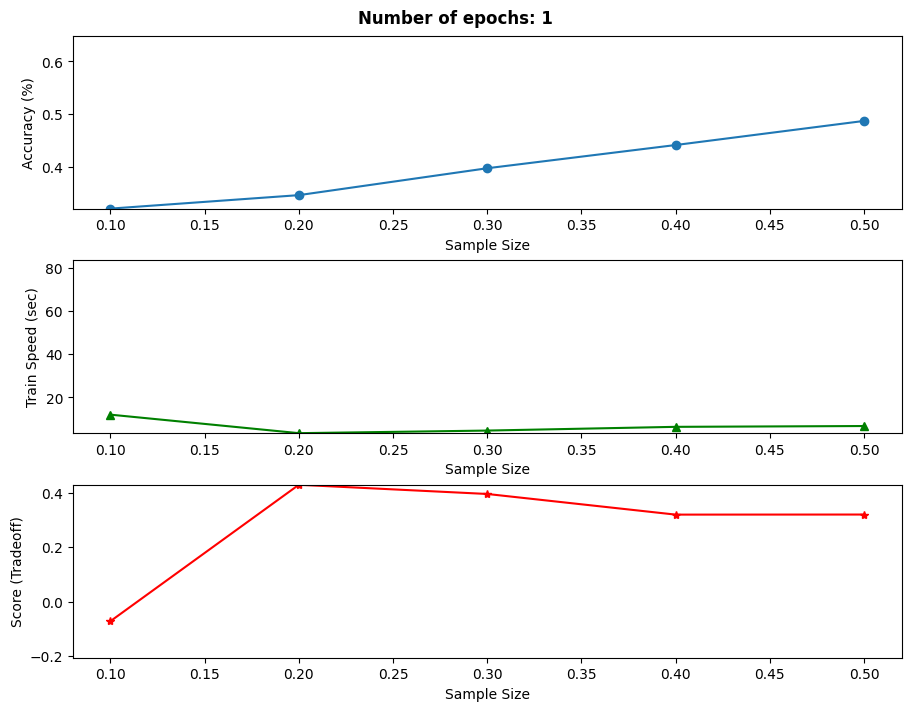

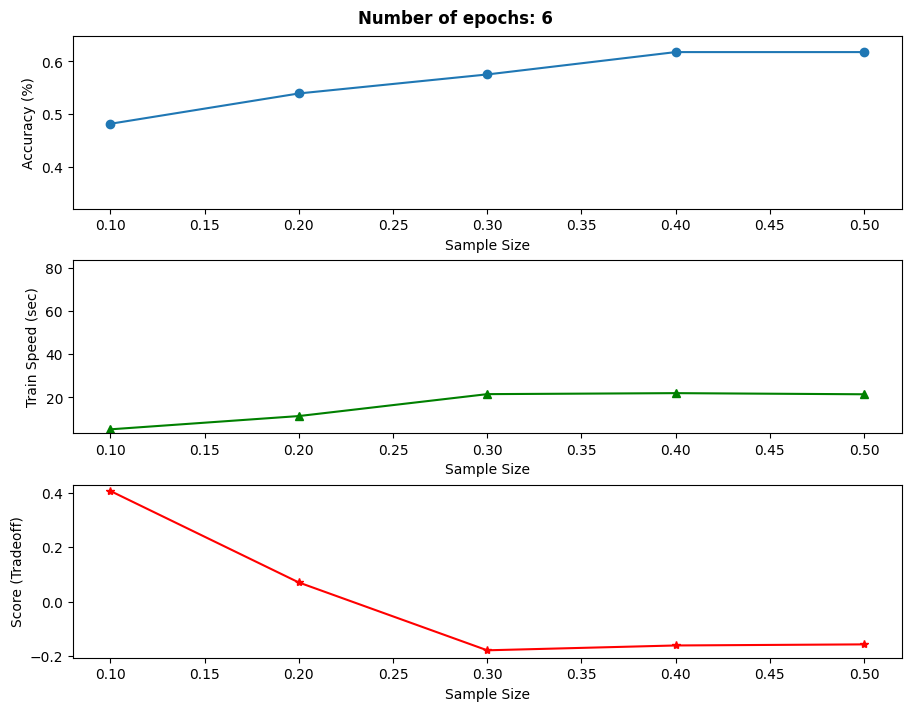

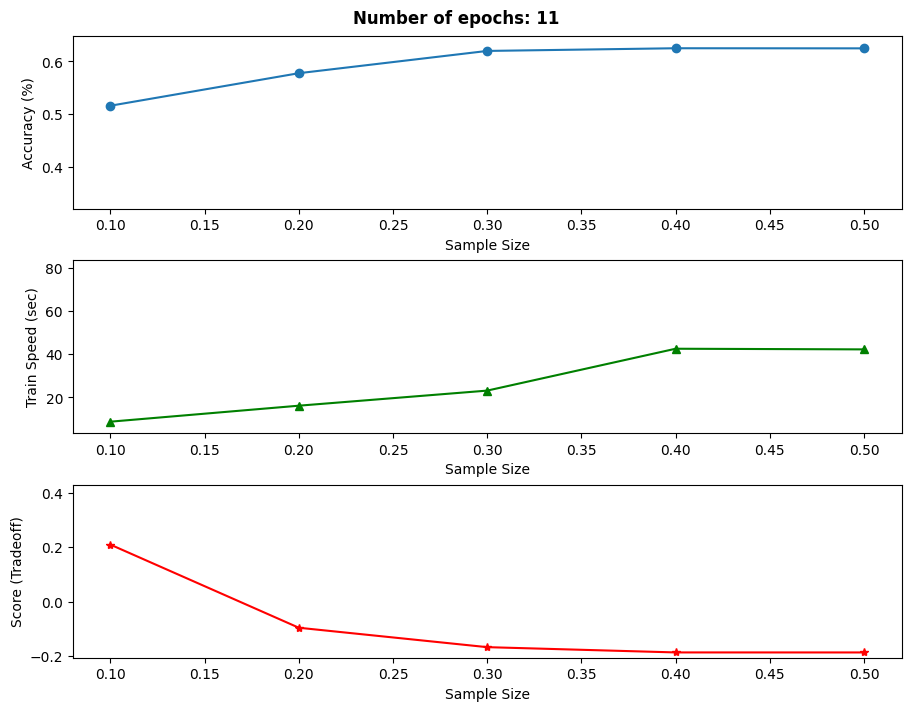

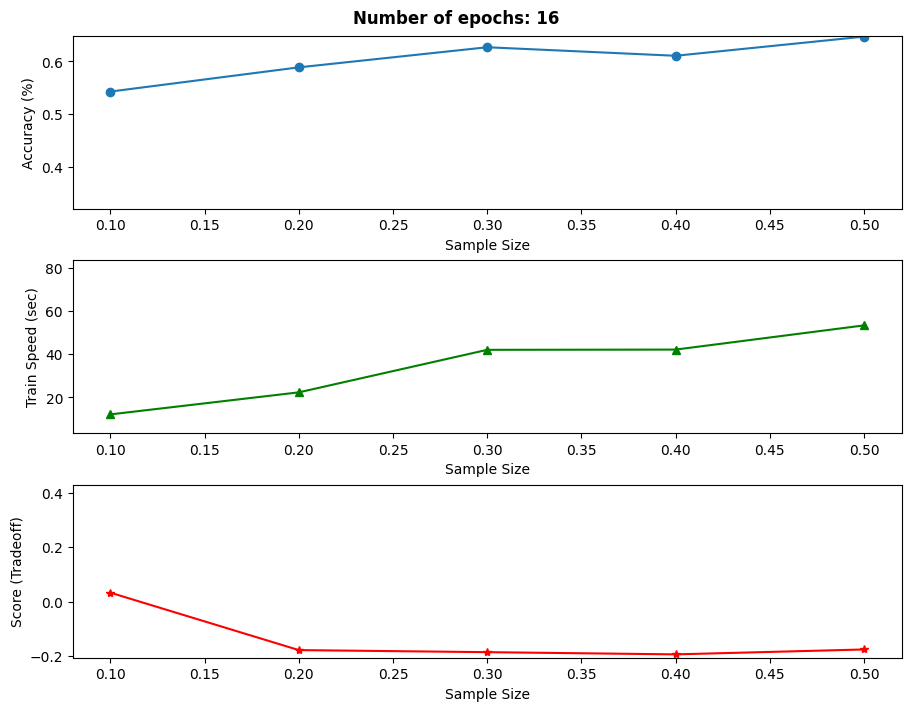

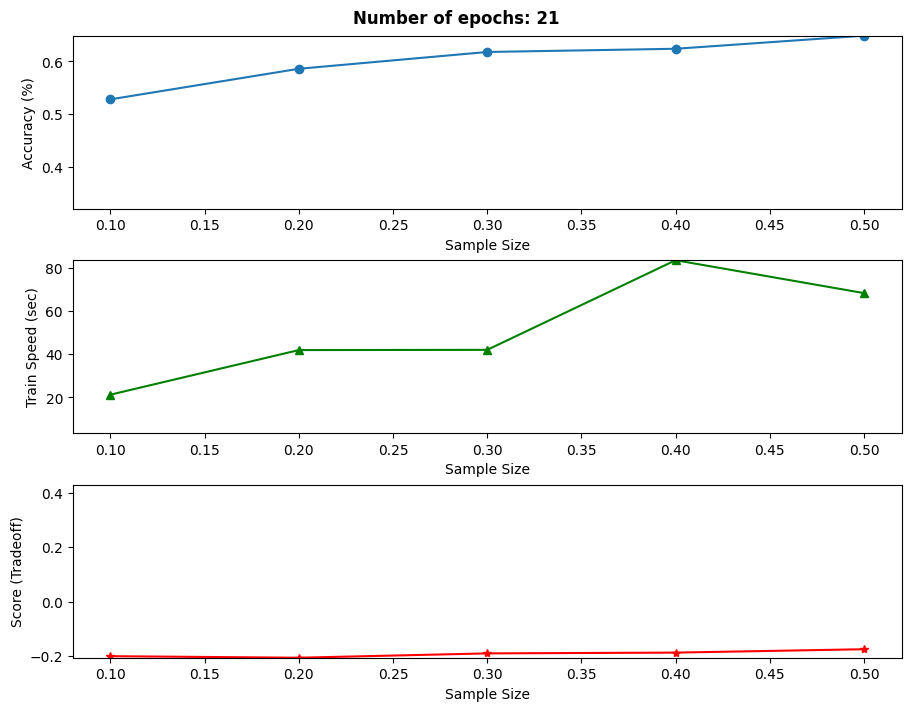

In [ ]:
if len(comb_of_neurons) == 1:
  for i in range(0, len(unique_epochs)):
    tmp_sample = []
    tmp_acc = []
    tmp_speed = []
    tmp_score = []
    for j in range(0, len(valid_comb_epochs)):
      if unique_epochs[i] == valid_comb_epochs[j]:
        tmp_sample.append(valid_comb_sample_size[j])
        tmp_acc.append(valid_comb_accuracy[j])
        tmp_speed.append(valid_comb_train_speed[j])
        tmp_score.append(valid_comb_score[j])
    # print(tmp_sample)
    # print(tmp_acc)
    # print(tmp_speed)
    # print(tmp_score)

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9,7), constrained_layout = True)
    fig.suptitle('Number of epochs: %i' % unique_epochs[i], fontweight ='bold')
    ax1.plot(tmp_sample, tmp_acc, '-o')
    ax1.set_xlabel("Sample Size")
    ax1.set_ylim(min(valid_comb_accuracy), max(valid_comb_accuracy))
    ax1.set_ylabel("Accuracy (%)")
    ax2.plot(tmp_sample, tmp_speed, '-g^')
    ax2.set_ylabel("Train Speed (sec)")
    ax2.set_ylim(min(valid_comb_train_speed), max(valid_comb_train_speed))
    ax2.set_xlabel("Sample Size")
    ax3.plot(tmp_sample, tmp_score, '-r*')
    ax3.set_ylabel("Score (Tradeoff)")
    ax3.set_ylim(min(valid_comb_score), max(valid_comb_score))
    ax3.set_xlabel("Sample Size")

Lock **sample size**. X-axis is the # of epochs and Y-axis is a metric, i.e., accuracy or training speed or score...

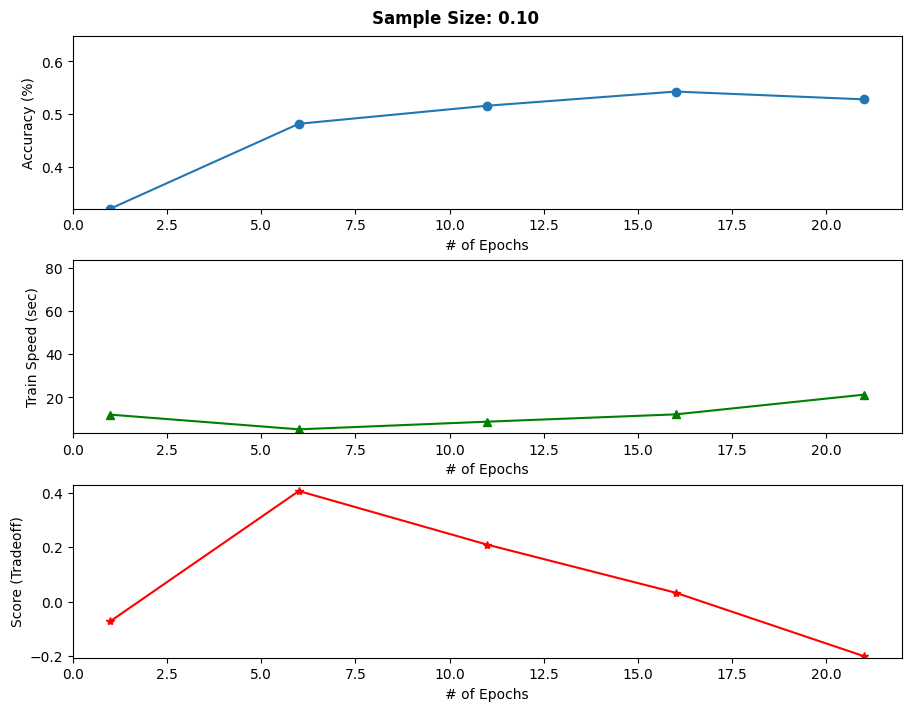

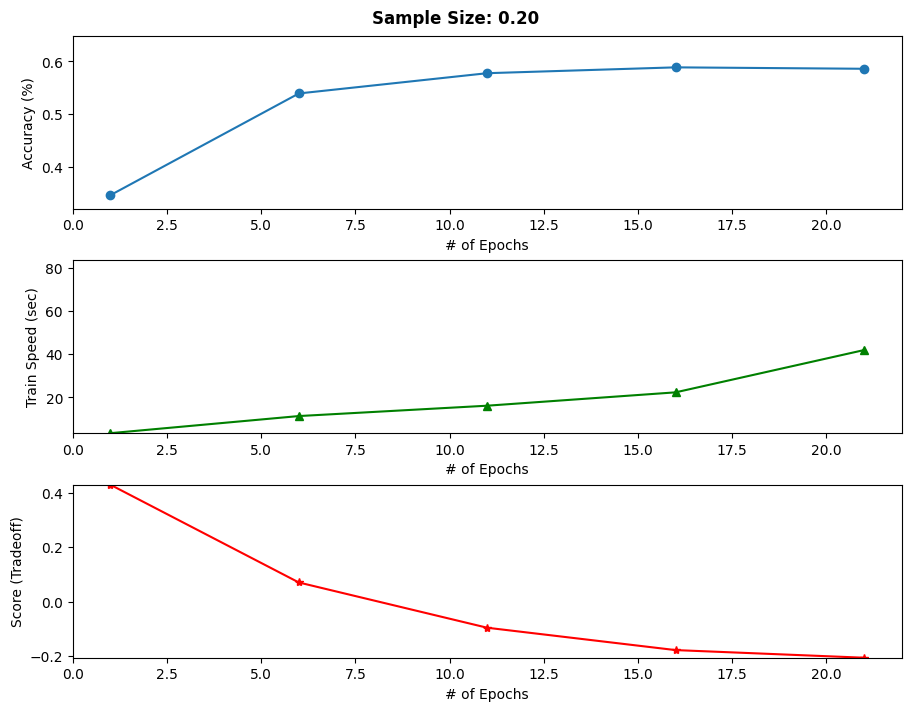

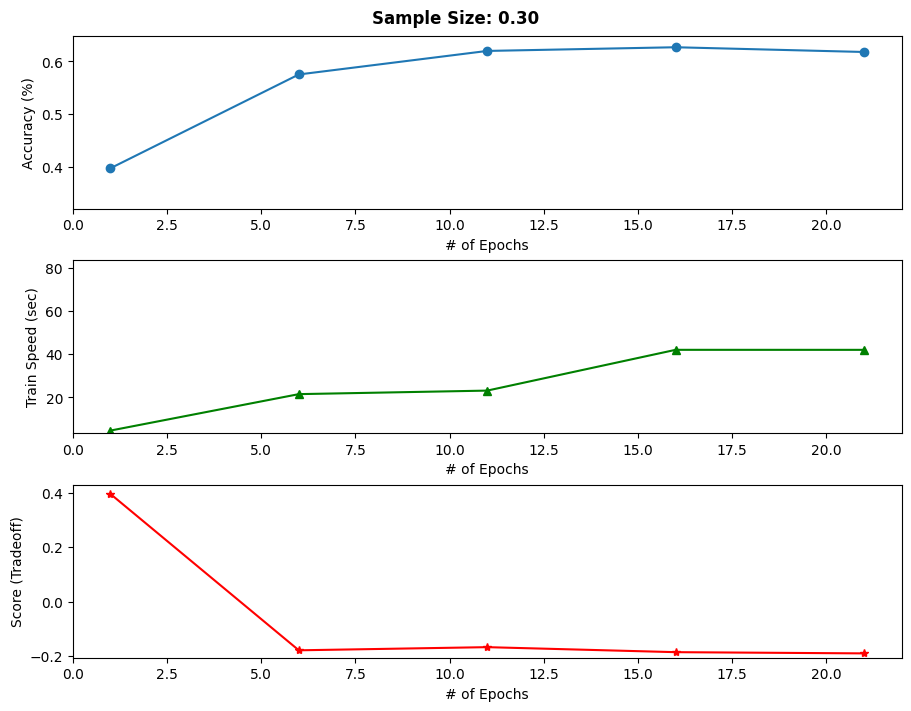

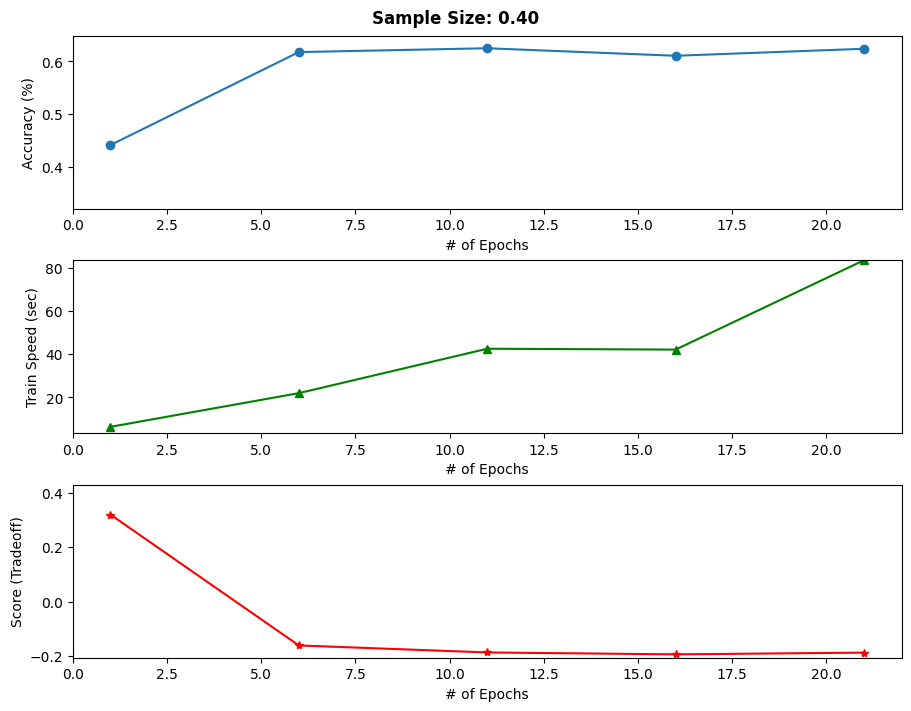

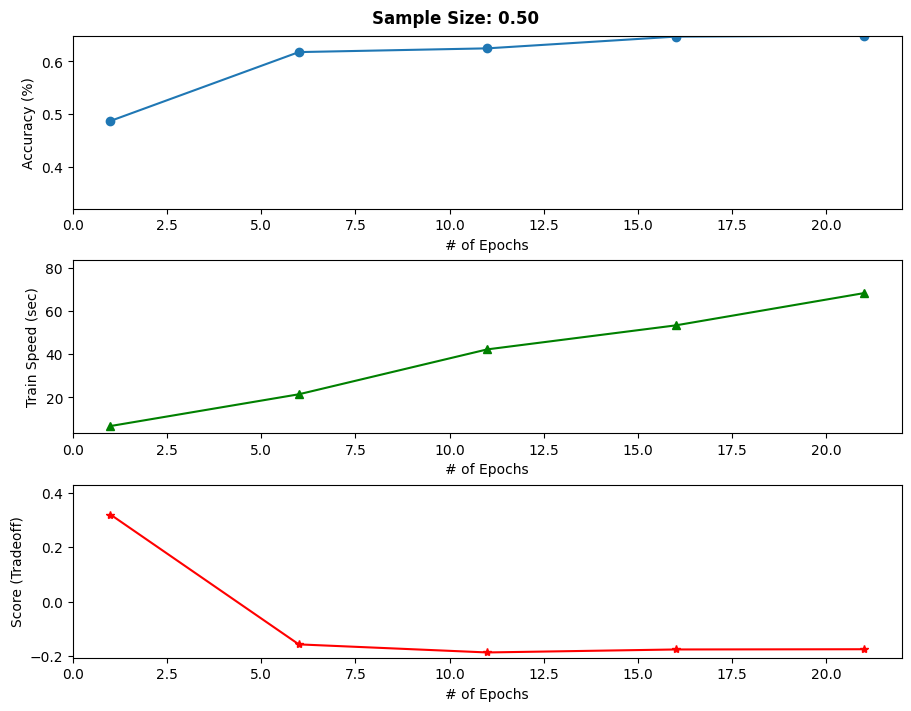

In [ ]:
if len(comb_of_neurons) == 1:
  for i in range(0, len(unique_sample)):
    tmp_epoch = []
    tmp_acc = []
    tmp_speed = []
    tmp_score = []
    for j in range(0, len(valid_comb_sample_size)):
      if unique_sample[i] == valid_comb_sample_size[j]:
        tmp_epoch.append(valid_comb_epochs[j])
        tmp_acc.append(valid_comb_accuracy[j])
        tmp_speed.append(valid_comb_train_speed[j])
        tmp_score.append(valid_comb_score[j])
    # print(tmp_epoch)
    # print(tmp_acc)
    # print(tmp_speed)
    # print(tmp_score)

    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9,7), constrained_layout = True)
    fig.suptitle('Sample Size: %.2f' % unique_sample[i], fontweight ='bold')
    ax1.plot(tmp_epoch, tmp_acc, '-o')
    ax1.set_xlabel("# of Epochs")
    ax1.set_ylim(min(valid_comb_accuracy), max(valid_comb_accuracy))
    ax1.set_ylabel("Accuracy (%)")
    ax2.plot(tmp_epoch, tmp_speed, '-g^')
    ax2.set_ylabel("Train Speed (sec)")
    ax2.set_ylim(min(valid_comb_train_speed), max(valid_comb_train_speed))
    ax2.set_xlabel("# of Epochs")
    ax3.plot(tmp_epoch, tmp_score, '-r*')
    ax3.set_ylabel("Score (Tradeoff)")
    ax3.set_ylim(min(valid_comb_score), max(valid_comb_score))
    ax3.set_xlabel("# of Epochs")

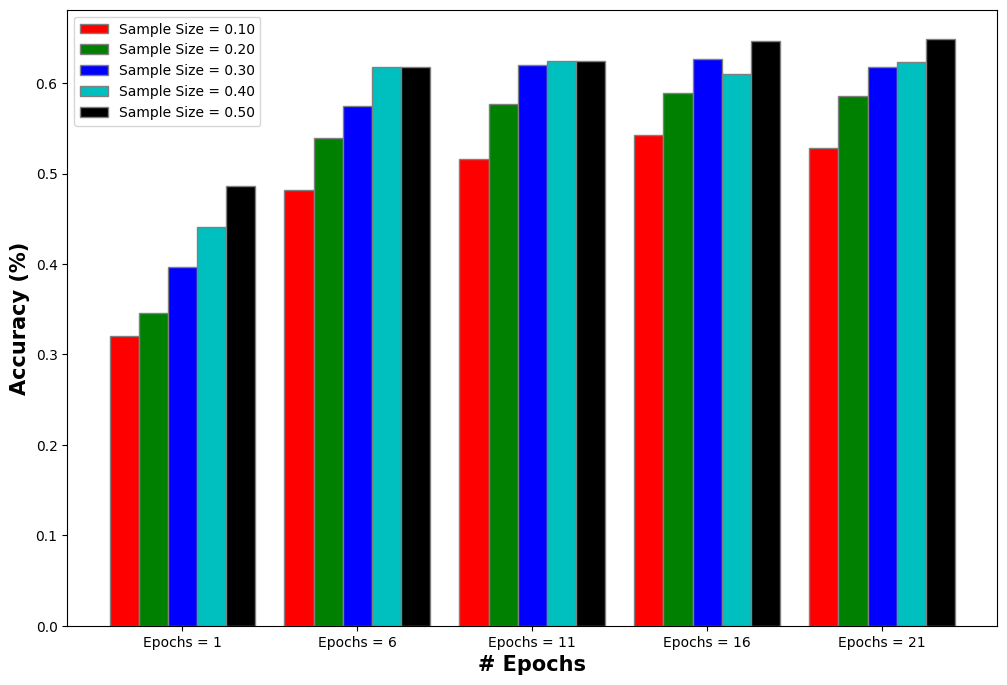

In [ ]:
if len(comb_of_neurons) == 1:
  tmp_accuracy = []
  tmp_speed = []
  tmp_trade = []
  for i in range(0, len(unique_sample)):
    tmp_accuracy2 = []
    tmp_speed2 = []
    tmp_trade2 = []
    for j in range(0, len(valid_comb_sample_size)):
      if unique_sample[i] == valid_comb_sample_size[j]:
        tmp_accuracy2.append(valid_comb_accuracy[j])
        tmp_speed2.append(valid_comb_train_speed[j])
        tmp_trade2.append(valid_comb_score[j])
    tmp_accuracy.append(tmp_accuracy2)
    tmp_speed.append(tmp_speed2)
    tmp_trade.append(tmp_trade2)

  # set width of bar
  barWidth = 1 / (len(unique_sample) + 1)
  fig = plt.subplots(figsize =(12, 8))

  # Set position of bar on X axis
  br = []
  for i in range(0, len(unique_sample)):
    if i == 0:
      tmp = np.arange(len(tmp_accuracy[0]))
    else:
      tmp = [x + barWidth for x in br[i - 1]]
    br.append(tmp)

  lst_of_colours = ['r','g','b','c','k','m','y']

  for i in range(0, len(unique_sample)):
    plt.bar(br[i], tmp_accuracy[i], color = lst_of_colours[i], width = barWidth, edgecolor ='grey', label ='Sample Size = %.2f' %unique_sample[i])

  # Adding Xticks
  plt.xlabel('# Epochs', fontweight ='bold', fontsize = 15)
  plt.ylabel('Accuracy (%)', fontweight ='bold', fontsize = 15)
  if len(unique_sample) % 2 == 0:
    plt.xticks([x - barWidth/2 for x in br[math.ceil(len(br)/2)]], epochs_plot_var)
  else:
    plt.xticks(br[math.floor(len(br)/2)], epochs_plot_var)

  plt.legend()
  plt.show()

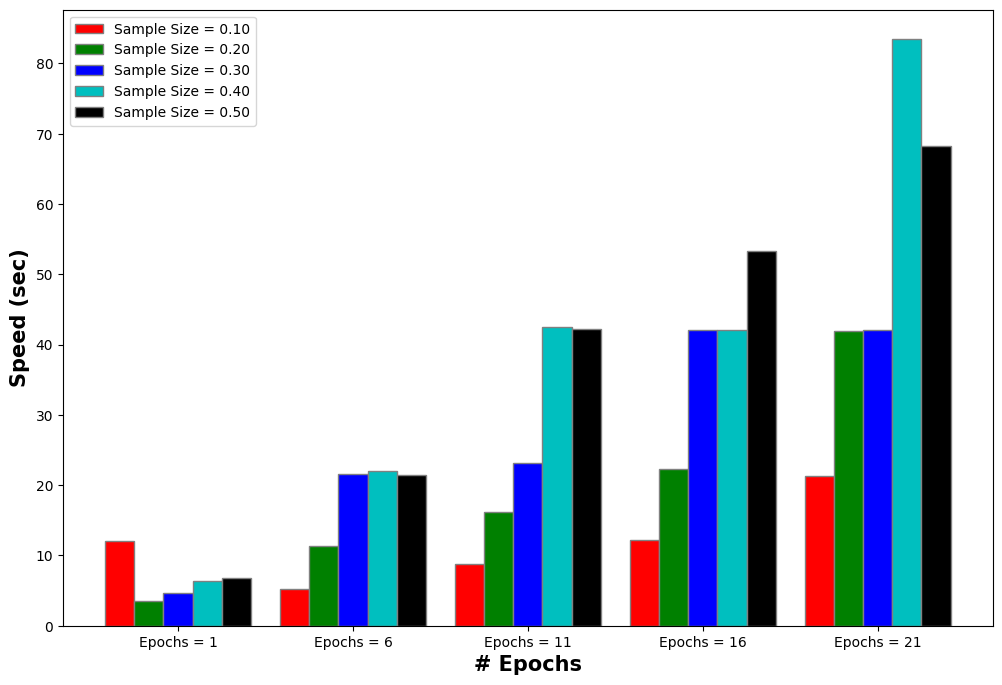

In [ ]:
if len(comb_of_neurons) == 1:
  fig = plt.subplots(figsize =(12, 8))

  # Set position of bar on X axis
  br = []
  for i in range(0, len(unique_sample)):
    if i == 0:
      tmp = np.arange(len(tmp_speed[0]))
    else:
      tmp = [x + barWidth for x in br[i - 1]]
    br.append(tmp)


  for i in range(0, len(unique_sample)):
    plt.bar(br[i], tmp_speed[i], color = lst_of_colours[i], width = barWidth, edgecolor ='grey', label ='Sample Size = %.2f' %unique_sample[i])

  # Adding Xticks
  plt.xlabel('# Epochs', fontweight ='bold', fontsize = 15)
  plt.ylabel('Speed (sec)', fontweight ='bold', fontsize = 15)
  if len(unique_sample) % 2 == 0:
    plt.xticks([x - barWidth/2 for x in br[math.ceil(len(br)/2)]], epochs_plot_var)
  else:
    plt.xticks(br[math.floor(len(br)/2)], epochs_plot_var)

  plt.legend()
  plt.show()

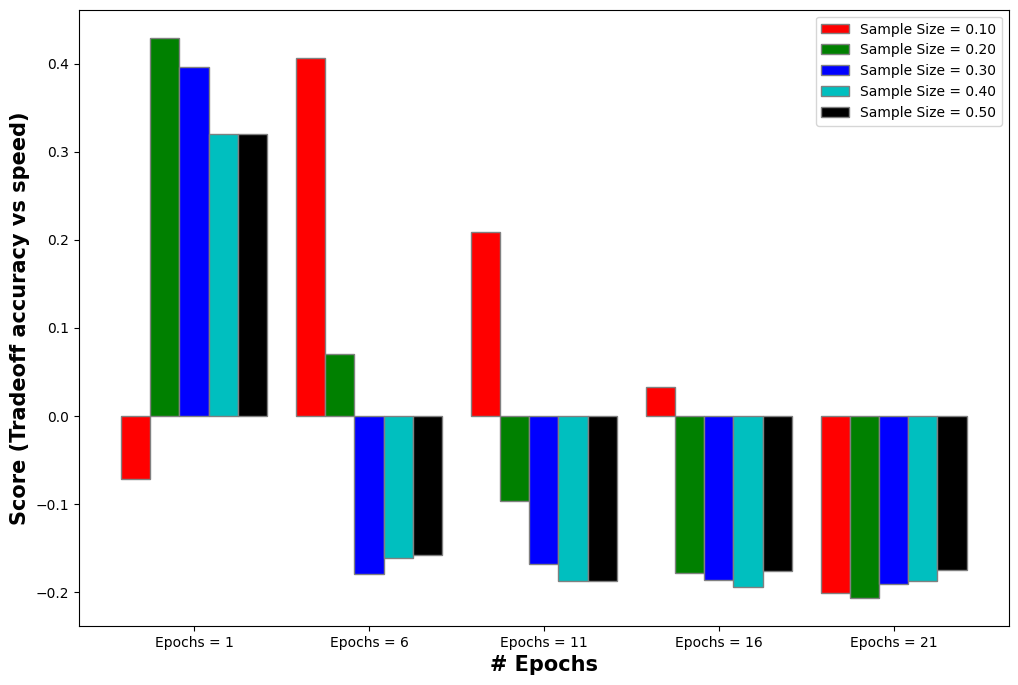

In [ ]:
if len(comb_of_neurons) == 1:
  fig = plt.subplots(figsize =(12, 8))

  # Set position of bar on X axis
  br = []
  for i in range(0, len(unique_sample)):
    if i == 0:
      tmp = np.arange(len(tmp_trade[0]))
    else:
      tmp = [x + barWidth for x in br[i - 1]]
    br.append(tmp)

  for i in range(0, len(unique_sample)):
    plt.bar(br[i], tmp_trade[i], color = lst_of_colours[i], width = barWidth, edgecolor ='grey', label ='Sample Size = %.2f' %unique_sample[i])

  # Adding Xticks
  plt.xlabel('# Epochs', fontweight ='bold', fontsize = 15)
  plt.ylabel('Score (Tradeoff accuracy vs speed)', fontweight ='bold', fontsize = 15)
  if len(unique_sample) % 2 == 0:
    plt.xticks([x - barWidth/2 for x in br[math.ceil(len(br)/2)]], epochs_plot_var)
  else:
    plt.xticks(br[math.floor(len(br)/2)], epochs_plot_var)

  plt.legend()
  plt.show()